<a href="https://colab.research.google.com/github/PremPrakash2207/loan_predection_model/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing necessary libraries & loading dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import pickle
import shap
import os


%matplotlib inline

In [ ]:
DATA_PATH = '/content/loan_approval_dataset.csv'
df = pd.read_csv(DATA_PATH)

In [ ]:
print(df.shape)
print(df.dtypes)
display(df.head())

(4269, 13)
loan_id                       int64
 no_of_dependents             int64
 education                   object
 self_employed               object
 income_annum                 int64
 loan_amount                  int64
 loan_term                    int64
 cibil_score                  int64
 residential_assets_value     int64
 commercial_assets_value      int64
 luxury_assets_value          int64
 bank_asset_value             int64
 loan_status                 object
dtype: object


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


# **Data Cleaning and Preprocessing**

In [ ]:
df = df.drop(columns=['loan_id'], errors='ignore')
print(df.isnull().sum())


no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64


In [ ]:
# Check all column names exactly as stored in the CSV
print("Column names in dataset:")
for col in df.columns:
    print(f"'{col}'")


Column names in dataset:
' no_of_dependents'
' education'
' self_employed'
' income_annum'
' loan_amount'
' loan_term'
' cibil_score'
' residential_assets_value'
' commercial_assets_value'
' luxury_assets_value'
' bank_asset_value'
' loan_status'


In [ ]:
df.columns = df.columns.str.strip()
print(df.columns.tolist())
df['loan_status'] = df['loan_status'].astype(str).str.strip().str.capitalize()
print(df['loan_status'].unique())
df['target'] = df['loan_status'].map({'Approved': 1, 'Rejected': 0})
print("\nTarget value counts:\n", df['target'].value_counts(dropna=False))


['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']
['Approved' 'Rejected']

Target value counts:
 target
1    2656
0    1613
Name: count, dtype: int64


In [ ]:
df['loan_status'] = df['loan_status'].astype(str).str.strip().str.capitalize()
print("\nUnique values in loan_status:", df['loan_status'].unique())



Unique values in loan_status: ['Approved' 'Rejected']


In [ ]:
# Normalize text columns to lowercase
df['education'] = df['education'].astype(str).str.strip().str.lower()
df['self_employed'] = df['self_employed'].astype(str).str.strip().str.lower()


In [ ]:
df['education_encoded'] = df['education'].apply(
    lambda x: 1 if 'grad' in x else 0
)


df['self_employed_encoded'] = df['self_employed'].apply(
    lambda x: 1 if x in ['yes', 'y', 'true'] else 0
)

In [ ]:
print(df['education'].unique()[:5])
print(df['self_employed'].unique()[:5])
print("\nEncoded columns preview:")
display(df[['education', 'education_encoded', 'self_employed', 'self_employed_encoded']].head())


['graduate' 'not graduate']
['no' 'yes']

Encoded columns preview:


,education,education_encoded,self_employed,self_employed_encoded
0,graduate,1,no,0
1,not graduate,1,yes,1
2,graduate,1,no,0
3,graduate,1,no,0
4,not graduate,1,yes,1


In [ ]:
print(df.isnull().sum())

essential_cols = ['income_annum', 'loan_amount', 'cibil_score', 'target']

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
target                      0
education_encoded           0
self_employed_encoded       0
dtype: int64


In [ ]:
# Drop rows where any essential values are missing
before = df.shape[0]
df = df.dropna(subset=essential_cols)
after = df.shape[0]
print(f"\nDropped {before - after} rows with missing essential values.")
print(f"Remaining rows after cleaning: {after}")




Dropped 0 rows with missing essential values.
Remaining rows after cleaning: 4269


In [ ]:
print("\nRemaining missing values after cleaning:\n", df.isnull().sum())



Remaining missing values after cleaning:
 no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
target                      0
education_encoded           0
self_employed_encoded       0
dtype: int64


In [ ]:
display(df.head())


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,target,education_encoded,self_employed_encoded
0,2,graduate,no,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,1,1,0
1,0,not graduate,yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,0,1,1
2,3,graduate,no,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected,0,1,0
3,3,graduate,no,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected,0,1,0
4,5,not graduate,yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected,0,1,1


In [ ]:
# Optional: drop original categorical columns after encoding
df = df.drop(columns=['education', 'self_employed', 'loan_status'])
display(df.head())


,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,target,education_encoded,self_employed_encoded
0,2,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1,1,0
1,0,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0,1,1
2,3,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0,1,0
3,3,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0,1,0
4,5,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0,1,1


In [ ]:
df = df.rename(columns={
    'target': 'loan_status',
    'education_encoded': 'education',
    'self_employed_encoded': 'self_employed'
})

column_order = [
    'no_of_dependents',
    'education',
    'self_employed',
    'income_annum',
    'loan_amount',
    'loan_term',
    'cibil_score',
    'residential_assets_value',
    'commercial_assets_value',
    'luxury_assets_value',
    'bank_asset_value',
    'loan_status'
]

# Reorder dataframe
df = df[column_order]

# Confirm the new structure
print(df.columns.tolist())

display(df.head())


['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,1,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,1,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


# **Exploratory Data Analysis (EDA)**

/tmp/ipython-input-329400811.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=df, palette='viridis')


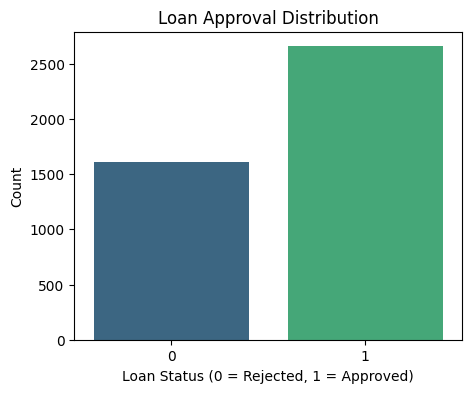

In [ ]:
# Loan approval distribution
plt.figure(figsize=(5,4))
sns.countplot(x='loan_status', data=df, palette='viridis')
plt.title("Loan Approval Distribution")
plt.xlabel("Loan Status (0 = Rejected, 1 = Approved)")
plt.ylabel("Count")
plt.show()

/tmp/ipython-input-1718799231.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_status', y='income_annum', data=df, palette='Set2')


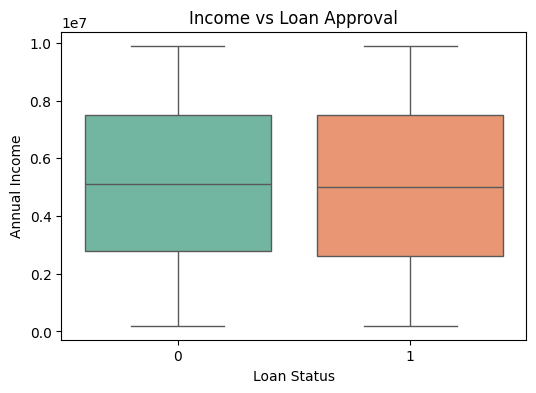

In [ ]:
# Income vs Loan Approval
plt.figure(figsize=(6,4))
sns.boxplot(x='loan_status', y='income_annum', data=df, palette='Set2')
plt.title("Income vs Loan Approval")
plt.xlabel("Loan Status")
plt.ylabel("Annual Income")
plt.show()


/tmp/ipython-input-1253046931.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_status', y='cibil_score', data=df, palette='Set3')


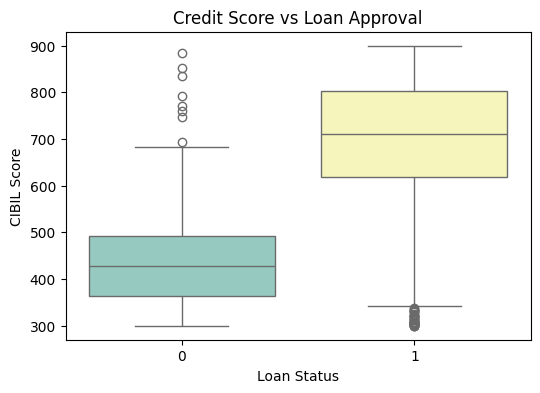

In [ ]:
# Credit Score vs Loan Approval
plt.figure(figsize=(6,4))
sns.boxplot(x='loan_status', y='cibil_score', data=df, palette='Set3')
plt.title("Credit Score vs Loan Approval")
plt.xlabel("Loan Status")
plt.ylabel("CIBIL Score")
plt.show()

/tmp/ipython-input-841761506.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_status', y='loan_amount', data=df, palette='cool')


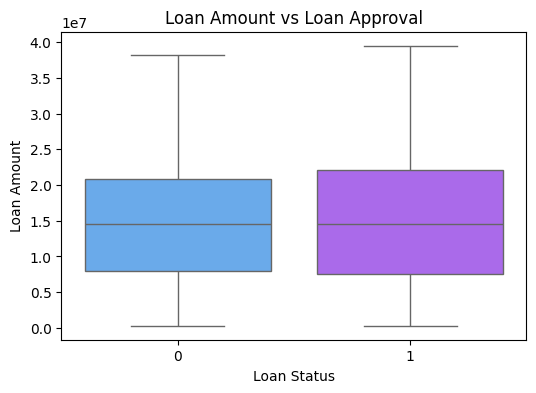

In [ ]:
# Loan Amount vs Loan Approval
plt.figure(figsize=(6,4))
sns.boxplot(x='loan_status', y='loan_amount', data=df, palette='cool')
plt.title("Loan Amount vs Loan Approval")
plt.xlabel("Loan Status")
plt.ylabel("Loan Amount")
plt.show()

# **Model Building - Decision Tree Classifier**


In [ ]:
#Split dataset into features (X) and target (y)
X = df.drop(columns=['loan_status'])
y = df['loan_status']

#Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 3415
Testing samples: 854


In [ ]:
# Initialize and train Decision Tree model
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [ ]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.97


In [ ]:
#Evaluate performance
acc = accuracy_score(y_test, y_pred)
print(f"{acc*100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))


97.42%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       318
           1       0.99      0.97      0.98       536

    accuracy                           0.97       854
   macro avg       0.97      0.98      0.97       854
weighted avg       0.98      0.97      0.97       854



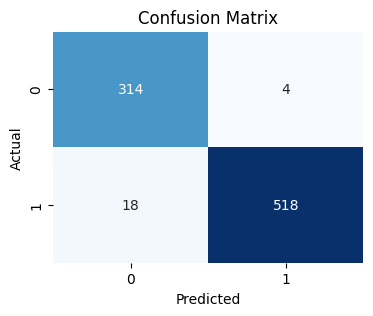

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Visualization and Interpretation of the Decision Tree**

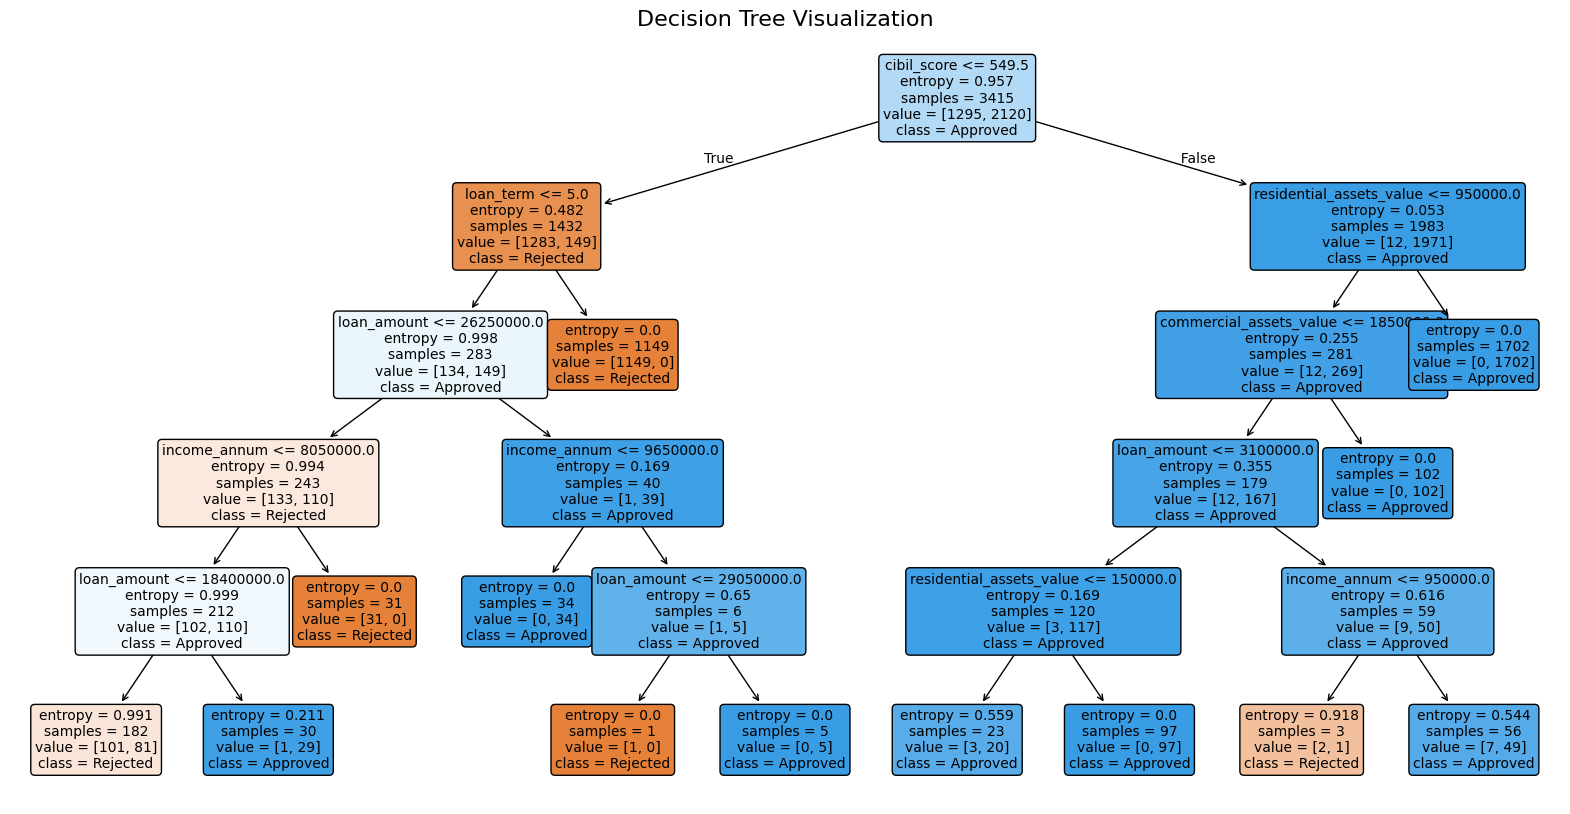

In [ ]:
#Decision Tree structure
plt.figure(figsize=(20,10))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=['Rejected', 'Approved'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()

In [ ]:
# Feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("how much each variable influences prediction):\n")
display(importance)

how much each variable influences prediction):



,Feature,Importance
6,cibil_score,0.814719
5,loan_term,0.134136
4,loan_amount,0.023085
7,residential_assets_value,0.013679
3,income_annum,0.011739
8,commercial_assets_value,0.002643
0,no_of_dependents,0.000000
2,self_employed,0.000000
1,education,0.000000
9,luxury_assets_value,0.000000


/tmp/ipython-input-776526176.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')


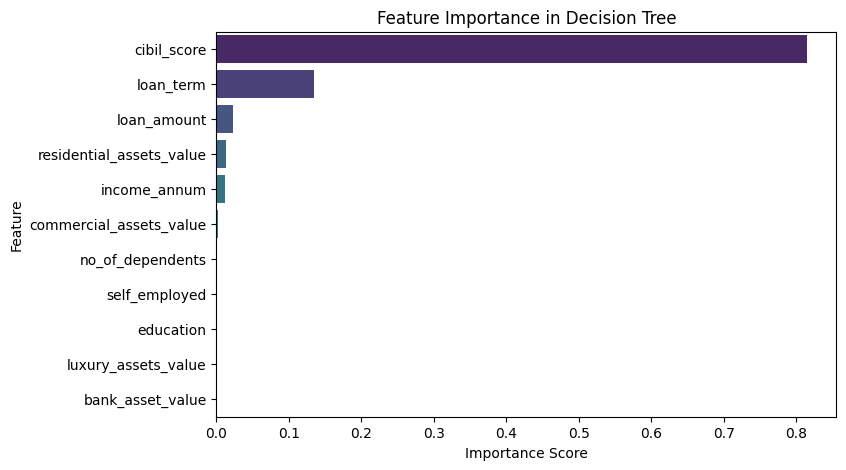

In [ ]:
# Bar chart of feature importance
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
plt.title("Feature Importance in Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# **Insights & Conclusion**

In [ ]:
# Loan approval distribution insight
approved = df['loan_status'].sum()
rejected = len(df) - approved
print(f"• Total Applications: {len(df)}")
print(f"• Approved: {approved}")
print(f"• Rejected: {rejected}\n")

• Total Applications: 4269
• Approved: 2656
• Rejected: 1613



In [ ]:
# Model performance
print(f"{acc*100:.2f}%")
print("\nThis means the model correctly predicts around "
      f"{acc*100:.2f}% of loan approvals/rejections.\n")


97.42%

This means the model correctly predicts around 97.42% of loan approvals/rejections.



In [ ]:
# Feature importance summary
top_features = importance.head(3)
print("Top Factors Influencing Loan Approval:")
for i, row in top_features.iterrows():
    print(f"   - {row['Feature']} (importance = {row['Importance']:.3f})")

Top Factors Influencing Loan Approval:
   - cibil_score (importance = 0.815)
   - loan_term (importance = 0.134)
   - loan_amount (importance = 0.023)


## **Evaluation of the Model on Unseen Data**

In [ ]:
# Example of new applicant data
new_data = pd.DataFrame({
    'no_of_dependents': [2],
    'education': [1],
    'self_employed': [0],
    'income_annum': [800000],
    'loan_amount': [100000],
    'loan_term': [36],
    'cibil_score': [780],
    'residential_assets_value': [400000],
    'commercial_assets_value': [0],
    'luxury_assets_value': [0],
    'bank_asset_value': [300000]
})

# Predict approval status
prediction = model.predict(new_data)[0]
probability = model.predict_proba(new_data)[0][1]

status = "Approved" if prediction == 1 else "Rejected "

print(f"Loan Prediction Result: {status}")
print(f"Probability of Approval: {probability*100:.2f}%")


Loan Prediction Result: Approved
Probability of Approval: 100.00%
